In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

# 꽃 데이터세트 다운로드
# 이 튜토리얼은 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉터리가 있습니다.

# flowers_photos/
#   daisy/
#   dandelion/
#   roses/
#   sunflowers/
#   tulips/

import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)
print(data_dir)


2.17.1
/root/.keras/datasets/flower_photos



이미지 개수 : 3670

하위 개수 : 6
[PosixPath('/root/.keras/datasets/flower_photos/dandelion'), PosixPath('/root/.keras/datasets/flower_photos/daisy'), PosixPath('/root/.keras/datasets/flower_photos/sunflowers'), PosixPath('/root/.keras/datasets/flower_photos/roses'), PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'), PosixPath('/root/.keras/datasets/flower_photos/tulips')]

하위 폴더 개수 : 5
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/daisy
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/tulips

하위 파일 개수 : 1
/root/.keras/datasets/flower_photos/LICENSE.txt

랜덤 하위 폴더 인덱스 :
0

랜덤 하위 폴더 :
/root/.keras/datasets/flower_photos/dandelion

랜덤 하위 폴더의 랜덤 이미지 :
341


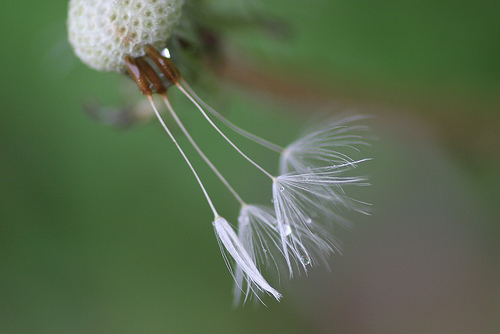

In [6]:
# 다운로드 후 꽃 사진의 사본 사용 가능

image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"\n이미지 개수 : {image_count}")

# data_dir 의 하위 디렉토리 가져오기

sub_list = list(data_dir.glob('*'))
sub_folders = [f for f in sub_list if os.path.isdir(f)]
sub_files = [f for f in sub_list if os.path.isfile(f)]

print(f"\n하위 개수 : {len(sub_list)}")
print(sub_list)

print(f"\n하위 폴더 개수 : {len(sub_folders)}")
for i in range(0,len(sub_folders)):
  print(sub_folders[i])

print(f"\n하위 파일 개수 : {len(sub_files)}")
for i in range(0,len(sub_files)):
  print(sub_files[i])

# '/' 다음의 문자열을 가져오는 함수

def get_last_part(path: str) -> str:
    return path.split('/')[-1]

# 이미지 가져오기

print("\n랜덤 하위 폴더 인덱스 :")
random_sub_folder_index = np.random.randint(0, len(sub_folders))
print(random_sub_folder_index)

print("\n랜덤 하위 폴더 :")
random_sub_folder_dir = sub_folders[random_sub_folder_index]
print(random_sub_folder_dir)

print("\n랜덤 하위 폴더의 랜덤 이미지 :")
random_sub_folder_image_list = list(data_dir.glob(f"{get_last_part(str(random_sub_folder_dir))}/*"))
random_sub_folder_image_index = np.random.randint(0, len(random_sub_folder_image_list))
print(random_sub_folder_image_index)
PIL.Image.open(str(random_sub_folder_image_list[random_sub_folder_image_index]))


In [7]:
# Keras 유틸리티를 사용해 데이터 로드

# 데이터세트 만들기

batch_size = 32
img_height = 180
img_width = 180

# 이미지의 80%는 훈련에 사용하고 20%는 유효성 검사에 사용한다.

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

class_names = train_ds.class_names


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


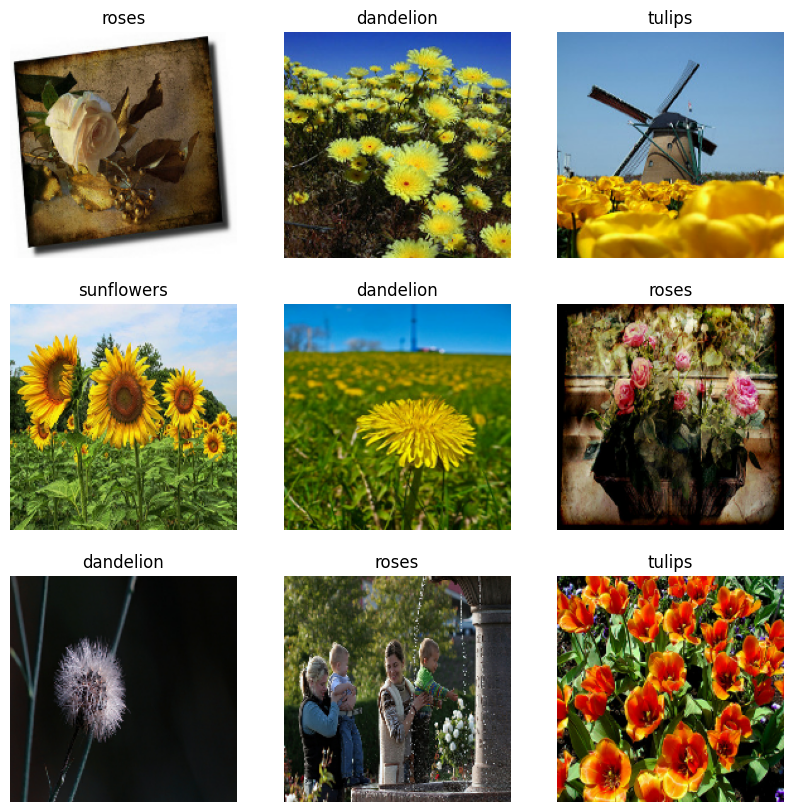

In [8]:
# 데이터 시각화 하기

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [9]:
# 데이터세트는 채널 3개의 RGB로 180*180 형상의 32개 이미지 묶음으로 구성

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# 데이터 표준화

# RGB 채널 값은 0~255 범위에 있어 신경망에 이상적이지 않다. 입력 값을 작게 만들어 0~1 범위로 표준화한다.

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

# 성능을 위한 데이터세트 구성

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


(32, 180, 180, 3)
(32,)


In [14]:
# 모델 레이어 생성

num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# 모델 컴파일

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# 모델 훈련

model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.3353 - loss: 1.4620 - val_accuracy: 0.5436 - val_loss: 1.1252
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5815 - loss: 1.0325 - val_accuracy: 0.6022 - val_loss: 1.0375
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.6631 - loss: 0.8897 - val_accuracy: 0.6131 - val_loss: 0.9632


In [21]:
# 미세 제어를 위해 tf.data 사용

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
  print(f.numpy())

class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print("\n클래스 :", class_names)

# 데이터세트를 학습 및 검증 세트로 분할

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print()
print("학습 데이터세트 길이 : ", tf.data.experimental.cardinality(train_ds).numpy())
print("검증 데이터세트 길이 : ", tf.data.experimental.cardinality(val_ds).numpy())
print()

# 파일 경로를 (img, label) 쌍으로 변환하는 간단한 함수 작성

def get_label(file_path):                                 # 파일 경로에서 해당 이미지의 레이블을 추출하여 one-hot 인코딩 형태로 반환하는 함수
  parts = tf.strings.split(file_path, os.path.sep)        #  - 파일 경로를 os.path.sep (운영체제의 파일 구분자) 기준으로 분리해 tensor로 반환한다. 예를 들어, "/root/data/cats/cat1.jpg" 같은 경로가 주어지면, parts는 ["", "root", "data", "cats", "cat1.jpg"]로 분리한다.
  one_hot = parts[-2] == class_names                      #  - 경로에서 파일 이름을 제외한 마지막 두 번재 항목이 클래스 이름 중에 포함되는지 검사해 Boolean Tensor 를 반환하낟.
  return tf.argmax(one_hot)                               #  - one_hot은 Boolean 값을 가진 텐서로, 텐서에서 가장 큰 값을 가지는 인덱스를 반환한다.

def decode_img(img):                                      # 이미지 파일을 디코딩하고 크기를 조정하여 네트워크에 입력할 수 있도록 준비하는 함수
  img = tf.io.decode_jpeg(img, channels=3)                #  - 이미지를 3채널(RGB)로 디코딩해 컬러 이미지를 반환
  return tf.image.resize(img, [img_height, img_width])    #  - 이미지를 지정한 크기로 변경해 반환한다.

def process_path(file_path):                              # 전체 이미지 경로에 대해 이미지와 해당 레이블을 가져오는 함수
  label = get_label(file_path)                            #  - file_path를 받아서 get_label() 함수로 해당 이미지의 레이블을 추출한다.
  img = tf.io.read_file(file_path)                        #  - tf.io.read_file()로 이미지 파일을 바이너리로 읽어 저장한다.
  img = decode_img(img)                                   #  - decode_img() 함수로 이미지를 디코딩하고 크기를 조절한다.
  return img, label                                       #  - 최종 이미지 텐서와 해당 레이블을 반환한다.

# Dataset.map을 사용해 image, label 쌍의 데이터세트를 작성

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1):
  print(f"Image shape : {image.numpy().shape} ___ Label : {label.numpy()}")


b'/root/.keras/datasets/flower_photos/daisy/5577555349_2e8490259b.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/4552571121_2677bcdec3.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/2720698862_486d3ec079_m.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3546455114_cd2dea5e02.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/17903104293_9138439e76.jpg'

클래스 : ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']

학습 데이터세트 길이 :  2936
검증 데이터세트 길이 :  734

Image shape : (180, 180, 3) ___ Label : 3


In [25]:
# 성능을 위한 데이터세트 구성

def configure_for_performance(ds):
  ds = ds.cache()                             # 데이터세트을 메모리에 캐시하여 I/O 성능을 개선한다.
  ds = ds.shuffle(buffer_size = 1000)         # 데이터세트를 무작위로 섞는다. buffer_size는 메모리 내에서 사용할 샘플 수이다.
  ds = ds.batch(batch_size)                   # 데이터세트를 batch_size로 나누어 배치 학습을 한다.
  ds = ds.prefetch(buffer_size = AUTOTUNE)    # 데이터 로딩을 비동기적으로 수행해 I/O 병목을 방지한다.
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


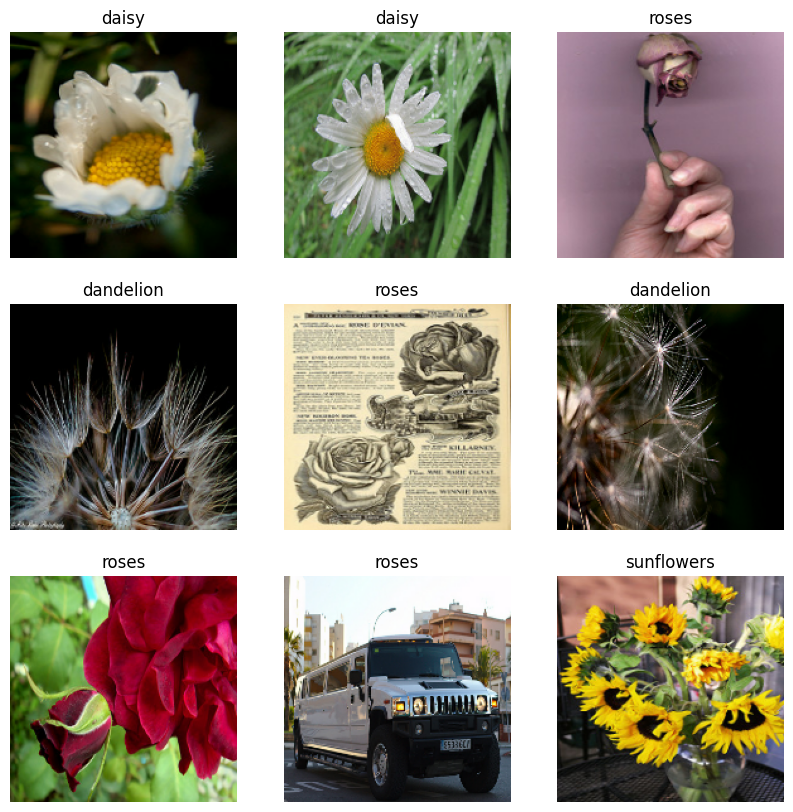

In [26]:
# 데이터 시각화

image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


In [27]:
# 모델 훈련

model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3
)


Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7155 - loss: 0.7638 - val_accuracy: 0.7343 - val_loss: 0.7615
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7773 - loss: 0.6089 - val_accuracy: 0.7316 - val_loss: 0.7235
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8411 - loss: 0.4546 - val_accuracy: 0.7480 - val_loss: 0.7657


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
ClassLabel(shape=(), dtype=int64, num_classes=5)
5


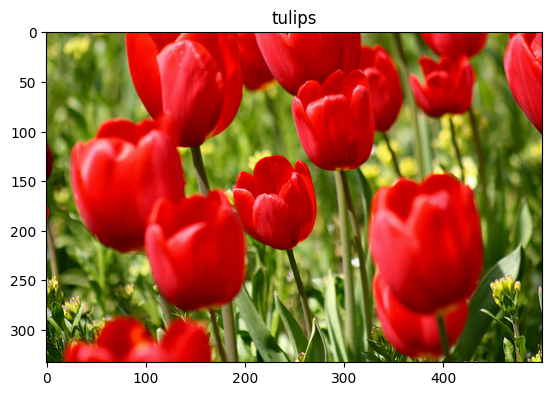

In [28]:
# TensorFlow 데이터세트 사용

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised = True
)

# 클래스 확인

print(metadata.features['label'])
num_classes = metadata.features['label'].num_classes
print(num_classes)


# 데이터세트에서 이미지 검색

get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


In [29]:
# 성능을 위해 셔플

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)
